### Intro
This notebook is a Jupyter-based starting point for someone developing a bot for ultimate tic-tac-toe (UTTT).

The absolute first step to developing a bot is to understand the game, and we suggest reading the rules and playing against the bot on https://www.uttt.ai/. That implementation uses the same rules as we do.

Before staring to code, come up with some human-level ideas about what makes a move good and what makes a move bad. Being able to explain in detail why a move falls into these two categories will be the first steps of your first bot.

---
Below is a cell for importing basic libraries and helping visualize the intermediate board states. You can run Jupyer notebook cells by activating them and pressing: Shift + Enter.


In [1]:
''' core imports '''
import numpy as np
import matplotlib.pyplot as plt

''' development imports'''
from time import perf_counter
from tqdm import tqdm

''' visualization imports '''
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['lightgrey', 'white'])
import matplotlib.colors as mcolors
tab10_names = list(mcolors.TABLEAU_COLORS) # create a list of colours

def checkerboard(shape):
    # from https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
    return np.indices(shape).sum(axis=0) % 2



---
### Bot template
You will be providing us a Python class that follows the following template.

It has two parts:
1) An initialized <b>name</b> (helping to make your bot your own). Please have this set to some default value.
2) A <b>.move</b> method that takes a dictionary as input


In [45]:
class bot_template:
    ''' 
    demonstrates the two minimal functions for an agent
    '''
    def __init__(self, name: str = 'bot_template'):
        self.name = name
        
    def move(self, board_dict: dict) -> tuple:
        '''
        the keywords for board_dict are:
        board_state: a 9x9 np.array showing which squares have which markers.
                     your markers at +1 and your opponent markers are -1.
                     open squares are 0
        active_box:  the coordinate for the active mini-board (indicates which 3x3 is currently playable)
                     a value of (-1, -1) is used if the whole board is valid
        valid_moves: a list of tuples indicating which positions are valid (in the 9x9 format)
        '''
        pass    
    

---
### Pre-programmed bots

Below are two very simple bots that are not very good.

In [46]:
class random_bot:
    '''
    this bot selects a random valid move
    '''
    def __init__(self, name = 'beep-boop'):
        self.name = name
    def move(self, board_dict):
        random_index = np.random.choice(len(board_dict['valid_moves']))
        return board_dict['valid_moves'][random_index]
    
class same_box_bot:
    '''
    this bot tries to play in the same mini board that it currently is in
    it will often return an invalid move, which is converted to a random move.
    '''
    def __init__(self, name = 'stuart'):
        self.name = name
        
    def move(self, board_dict):
        return board_dict['active_box']

class first_bot(bot_template):
    '''
    the board_dict provides a list of valid moves
    this bot plays the first entry of that list
    '''
    def __init__(self, name = 'dozer'):
        self.name = name
        
    def move(self, board_dict):
        return board_dict['valid_moves'][0]


--- 
### Game engine

The class below contains all the information and logic to run the game in this notebook

Run the following cell, and we will look at the methods later in this notebook.

In [47]:
class uttt_engine():
    def __init__(self):
        self.active_box = (-1,-1)    # (-1,-1) means any box can be played in
        self.board_state = np.zeros((9,9))
        self.finished_boxes = np.zeros((3,3)) # 1 for agent1, -1 for agent2. "6" indicates stalemate
        self.finished = False
        self.finished_win = False
        self.finished_stale = False
        self.current_player = 1 # starting player
        self.game_log = ''

    ''' -------------- Initialization ------'''
    def load_agents(self, agent1: bot_template, agent2: bot_template) -> None:
        ''' agent1 and agent2 are uttt agents '''
        self.agents = [agent1, agent2]
        
    ''' --------------- Logging ----------- '''
    
    def get_game_log(self) -> str:
        ''' returns the current game encoding (for visualization) '''
        return self.game_log

    def log_move(self, position: tuple) -> None:
        # convert tuple to string, append character to existing game code
        offset = 32
        self.game_log += (chr(position[0]*9 + position[1] + offset))
        
    def load_game(self, game_string:str) -> None:
        ''' assumes the game string is valid (this is not strictly enforced) '''
        for encoded_position in game_string:
            # update game board
            self.move(self.unconvert(encoded_position), log=False)

    def unconvert(self, symbol):
        ''' part of loading a game from a string '''
        offset = 32
        int_position = ord(symbol) - offset
        return (int_position//9, int_position%9)
    
    ''' ------------- Logic --------------- '''
    
    def get_query_dict(self) -> dict:
        ''' can be used in development to understand what the bot is being provided for logic '''
        return {'board_state': self.board_state * self.current_player,
                'active_box':  self.active_box,
                'valid_moves': self.get_valid_moves()}
    
    def query_player(self, loud: bool = False) -> None:
        '''
        send a request to a player instance for a move
        updates the game board with the desired move
        if no valid move is returned, a random move is played for that agent
        the "loud" argument can be used to hear/silence warnings
        '''
        # check agents are loaded
        if not hasattr(self, 'agents'):
            print('must load agents')
            return 
        
        # check game is not finished
        if self.finished:
            print('no valid moves in terminal state')
            #print("(something went wrong, you shouldn't be here)")
            #print('put in a "game_finished" check somewhere')
            return
        
        # send the request with board information in the form of a dictionary
        temp_valid_moves = self.get_valid_moves()
        temp_valid_moves = [tuple(x) for x in temp_valid_moves]

        try:
            desired_move = tuple(self.agents[0].move(self.get_query_dict()))
            if desired_move not in temp_valid_moves:
                random_index = np.random.choice(np.arange(len(temp_valid_moves)))
                desired_move = tuple(temp_valid_moves[random_index])
                if loud:
                    print(f'warning: {self.agents[0].name} played an invalid move. converting to random valid alternative')
            # update board
            self.move(position = desired_move)
            
        except:
            # shouldn't get here, but this chunk of code exists for safety
            if loud:
                print(f'warning: exception raised in "query" for {self.agents[0].name}')
            random_index = np.random.choice(np.arange(len(temp_valid_moves)))
            desired_move = tuple(temp_valid_moves[random_index])

            # update board
            self.move(position = desired_move)
            
    def switch_active_player(self) -> None:
        ''' switch the current player value and the agent list '''
        # this is called at the end of .move()
        self.agents = self.agents[::-1]
        self.current_player *= -1
        
    def getwinner(self) -> int:
        ''' new method
        returns the integer indicating the winning player
        (subject to change)
        '''
        if self.finished:
            if self.finished_win:
                return self.current_player
            else:
                return 0
    
    def check_validity(self, position: tuple) -> bool:
        ''' check whether position - a tuple - is valid '''
        box_validity = (self.active_box == self.map_to_major(position)) \
                        or (self.active_box == (-1,-1))
        open_validity = (self.board_state[position] == 0)
        return box_validity and open_validity
    
    def check_line(self, box: np.array) -> bool:
        '''
        box is a (3,3) array (typically a mini-board)
        returns True if a line is found
        '''
        for i in range(3):
            if abs(sum(box[:,i])) == 3: return True # horizontal
            if abs(sum(box[i,:])) == 3: return True # vertical

        # diagonals
        if abs(box.trace()) == 3: return True
        if abs(np.rot90(box).trace()) == 3: return True

    def map_to_major(self, position: tuple) -> tuple:
        '''
        converts position to major coordinates
        eg: (5,3) -> (1,1)
        '''
        return(position[0]//3, position[1]//3)

    def map_to_minor(self, position: tuple) -> tuple:
        '''
        converts position into mini coordinates
        eg: (5,3) -> (2,0)
        '''
        return (position[0]%3, position[1]%3)

    def check_full_stale(self) -> None:
        ''' this might be impossible? '''
        # get number of invalid boxes
        
        if (self.finished_boxes == 0).sum() == 0:
            self.finished_stale = True
            self.finished = True

    def move(self, position: tuple, log: bool = True) -> None:
        '''
        the main game logic. board updates and logic checks.
        '''
        if self.finished:
            print('no move played, game is finished')
            return
        
        if self.check_validity(position):
            
            # log move
            if log:
                self.log_move(position)
                
            # place marker
            self.board_state[position] = self.current_player
            
            # select both scales
            temp_box = self.map_to_major(position)
            temp_minor_box = self.board_state[3*temp_box[0]:3*temp_box[0]+3,
                                              3*temp_box[1]:3*temp_box[1]+3]
            
            ''' check line at minor scale '''
            if self.check_line(temp_minor_box):
                self.finished_boxes[self.map_to_major(position)] = self.current_player
                
                # check line at major scale
                if self.check_line(self.finished_boxes):
                    self.finished_win = True
                    self.finished = True
                    return # end the whole thing immediately (will cause stalemate bug without this !)

            # if no squares are open, mark as stale
            elif (temp_minor_box == 0).sum() == 0:
                self.finished_boxes[self.map_to_major(position)] = 6 # indicates stalemate in that box
            
            ''' is the whole game board stale? '''
            # if it's stale, set the appropriate flags
            self.check_full_stale()
            
            ''' calculate active box '''
            self.active_box = self.map_to_minor(position)
            # if that box is won or stale flag it
            if self.finished_boxes[self.active_box] != 0:
                self.active_box = (-1,-1)

            # switch player
            self.switch_active_player()

    def get_valid_moves(self) -> np.array:
        '''
        returns an array (N,2) of valid moves
        '''
        
        if self.finished:
            print('no valid moves in terminal state')
            return np.empty(0)
        # define masks that cover the board
        # across the whole board
        full_board_mask = (self.board_state == 0)
        # active square
        active_box_mask = np.zeros((9,9),dtype=bool)
        # identifies finished major boxes
        a = np.repeat(self.finished_boxes,3).reshape(3,9)
        b = np.tile(a,3).reshape(9,9)
        finished_box_mask = (b == 0)
        
        if self.active_box == (-1,-1):
            active_box_mask[:] = True
            active_box_mask *= finished_box_mask
        else:
            active_box_mask[3*self.active_box[0]:3*self.active_box[0]+3,
                            3*self.active_box[1]:3*self.active_box[1]+3] = True

        # return get union of maps
        return np.array(np.where(active_box_mask * full_board_mask)).T

    ''' ------------- Visualization ------- '''
    
    def draw_valid_moves(self) -> None:
        ''' visualization tool
        plots the valid moves as purple squares
        to be called after the .draw_board() method
        '''
        moves = self.get_valid_moves()
        plt.scatter(moves[:,0],moves[:,1],marker='s',c='purple',alpha=0.3, s=50)
        
    def draw_board(self, marker_size: int = 100, ticks: str = 'off') -> None:
        ''' visualization tool
        plots a checkerboard and markers for all plays.
        lines distinguish mini-boards and finished boards are coloured in
        '''
        plt.imshow(checkerboard((9,9)), cmap=cmap, origin='lower')
        for i in [-0.5,2.5,5.5, 8.5]:
            plt.axvline(i,c='k')
            plt.axhline(i,c='k')
            
        if ticks == 'off':
            plt.axis('off')
        else:
            plt.xticks(np.arange(9))

        plt.scatter(*np.where(self.board_state == -1), marker='x', s=marker_size, c='tab:blue')
        plt.scatter(*np.where(self.board_state == 1),  marker='o', s=marker_size, c='tab:orange')
        
        x_boxes = np.where(self.finished_boxes == -1)
        o_boxes = np.where(self.finished_boxes == 1)
        plt.scatter(x_boxes[0]*3+1,x_boxes[1]*3+1,marker='s',s=marker_size*50,alpha=0.6,c='tab:blue')
        plt.scatter(o_boxes[0]*3+1,o_boxes[1]*3+1,marker='s',s=marker_size*50,alpha=0.6,c='tab:orange')
        
        stale_boxes = np.where(self.finished_boxes == 6)
        plt.scatter(stale_boxes[0]*3+1, stale_boxes[1]*3+1, marker='s', s=marker_size*50, alpha=0.3,c='k')



---
### Initializing a game and inspecting the methods

We are going to initialize an instance of the UTTT_engine. From there we will investigate available methods to help you develop your bot.

In [48]:
# initialize the engine
engine = uttt_engine()

# load two agents into the game
# We will be overriding some bot logic
engine.load_agents(random_bot(name = 'the bot known as player 1'),
                   random_bot(name = 'the second bot'))


The engine has a built-in visualization utility and because this is a new board, it starts blank

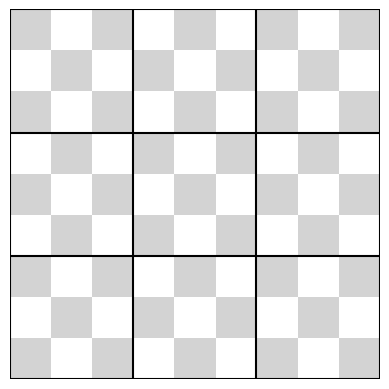

In [49]:
engine.draw_board()


Let's make this slightly more interesting by playing 5 random moves.


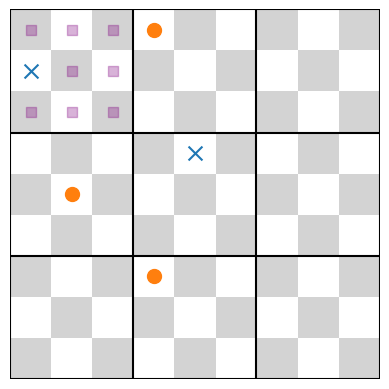

In [50]:
# note: setting a seed ensures the same game is played because these bots use the np.random module
np.random.seed(12345)

# Play 5 moves. If the game ends, stop querying the bots
for i in range(5):
    if engine.finished == False:
        engine.query_player()
        
# draw the board
engine.draw_board()

# draw the valid moves for the current player
engine.draw_valid_moves()

We played 5 moves which shows that the first move is played by the <b>o</b> player.
The purple square markers indicate which positions can be played.<br>
X and Y ticks are shown below and board positions are identified by a tuple: (horizontal axis, vertical axis)

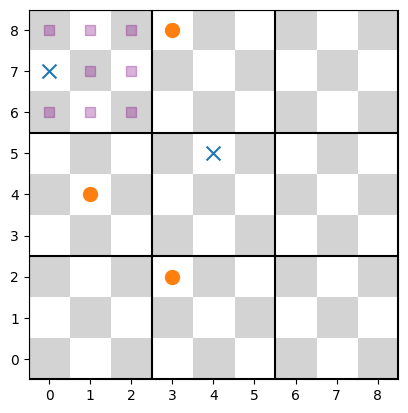

In [51]:
engine.draw_board(ticks='on')
engine.draw_valid_moves()

Let's now look at what your bot can see. The <b>query_dictionary</b> is provided to your bot in the <b>move</b> function, and we can access it directly.

In [52]:
engine.get_query_dict()

{'board_state': array([[-0., -0., -0., -0., -0., -0., -0.,  1., -0.],
        [-0., -0., -0., -0., -1., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -1., -0., -0., -0., -0., -0., -1.],
        [-0., -0., -0., -0., -0.,  1., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.]]),
 'active_box': (0, 2),
 'valid_moves': array([[0, 6],
        [0, 8],
        [1, 6],
        [1, 7],
        [1, 8],
        [2, 6],
        [2, 7],
        [2, 8]], dtype=int64)}

There are 3 keys: <br>
 - <b>board_state</b> is the 9x9 board in an array. You may notice that it has a weird rotation when printed out, but the position (0, 7) does indeed contain a "1" indicating a self-marker. This follows the convention (in the visualization) that a position is the x-axis followed by the y-axis with the origin in the bottom left corner.

In [53]:
engine.get_query_dict()['board_state'][0, 7]

1.0

- <b>active_box</b> is a quality-of-life argument indicating which <b>mini-board</b> is currently active. It follows a similar convection of counting x-axis then y-axis with the origin in the bottom left corner.



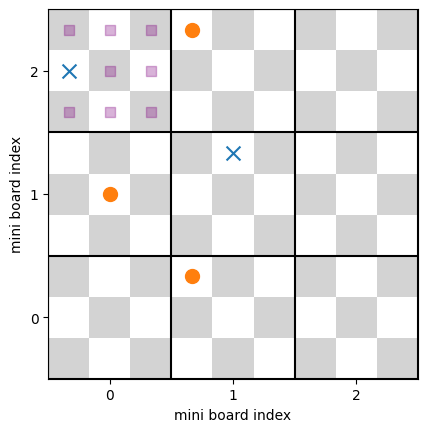

In [54]:
engine.draw_board()
engine.draw_valid_moves()

# displays the mini-board indices
ax = plt.gca()
ax.axis('on')
ax.set_xlabel('mini board index')
ax.set_ylabel('mini board index')
ax.set_xticks([1,4,7],[0,1,2])
ax.set_yticks([1,4,7],[0,1,2])

 - and finally, <b> valid_moves </b> is a list of positions that would be valid moves.
 

---
### Alternative visualization
Let's finish this game and look at a more attractive game visualizer



In [55]:
# query players until the game is finished
while engine.finished == False:
    engine.query_player()
    
print(engine.agents[0].name, 'wins!')


the second bot wins!


The game is encoded in the string:

In [56]:
# the game 
print(engine.get_game_log())

='-IC8W6Z,N[0RnV"(9lc?%1UeMX/<5iY4fPjpgTm]@:oSh_E>2aKG^ +J!)BA*`


Copy that string and go to https://uttt-visual.vercel.app/. <br>
There is a box called <b>game data</b> where you can paste the game.<br>
It will show the final state, but you can run through the game by pressing <b>run</b>.

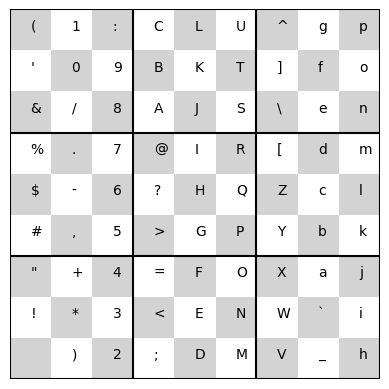

In [57]:

# For interest, each position is given a character and the order of the characters in the encoding
# shows when positions were played 

# remove the markers by re-initializing the engine
engine = uttt_engine()
engine.draw_board()

# visualize the characters in their positions
offset = 32
for i in range(81):
    plt.text(i//9, i%9, chr(i+offset), ma='center')


---
### A mid-tier bot
Provided below is a bot that performs better than the random baseline, but there is considerably room for improvement. That's where you come in.

At a high level, the bot only looks at the current mini-board. If there is an opportunity to block the opponent, it will take that position. If not, the bot will try to take the middle. If that's not available, it will try to take a random corner. Finally it will take any valid move (which would be an edge by process of elimination).

If it is provided a full-board for valid moves it follows a similar procedure to select which mini-board to play in. Then it applies the above logic.

In [58]:
class finns_heuristic_bot:
    '''
    this could use a significant refactor
    this provides a lot of methods to pull and remix
    really doesn't use valid_moves
    (valid moves can be determined from board_state and active_box)
    
    it's not very strong. you should be able to beat this fairly easily.
    '''
    
    ''' ------------------ required function ---------------- '''
    
    def __init__(self,name: str = 'Aljoscha') -> None:
        self.name = name
        
    def move(self, board_dict: dict) -> tuple:
        ''' wrapper
        apply the logic and returns the desired move
        '''
        return tuple(self.heuristic_mini_to_major(board_state = board_dict['board_state'],
                                                  active_box = board_dict['active_box'],
                                                  valid_moves = board_dict['valid_moves']))
    
    
    ''' --------- generally useful bot functions ------------ '''
    
    def _check_line(self, box: np.array) -> bool:
        '''
        box is a (3,3) array
        returns True if a line is found, else returns False '''
        for i in range(3):
            if abs(sum(box[:,i])) == 3: return True # horizontal
            if abs(sum(box[i,:])) == 3: return True # vertical

        # diagonals
        if abs(box.trace()) == 3: return True
        if abs(np.rot90(box).trace()) == 3: return True
        return False

    def _check_line_playerwise(self, box: np.array, player: int = None):
        ''' returns true if the given player has a line in the box, else false
        if no player is given, it checks for whether any player has a line in the box'''
        if player == None:
            return self._check_line(box)
        if player == -1:
            box = box * -1
        box = np.clip(box,0,1)
        return self._check_line(box)
    
    def pull_mini_board(self, board_state: np.array, mini_board_index: tuple) -> np.array:
        ''' extracts a mini board from the 9x9 given the its index'''
        temp = board_state[mini_board_index[0]*3:(mini_board_index[0]+1)*3,
                           mini_board_index[1]*3:(mini_board_index[1]+1)*3]
        return temp

    def get_valid(self, mini_board: np.array) -> np.array:
        ''' gets valid moves in the miniboard'''
        return np.where(mini_board == 0)

    
    def get_finished(self, board_state: np.array) -> np.array:
        ''' calculates the completed boxes'''
        opp_boxes = np.zeros((3,3))
        self_boxes = np.zeros((3,3))
        stale_boxes = np.zeros((3,3))
        # look at each miniboard separately
        for _r in range(3):
            for _c in range(3):
                temp_miniboard = self.pull_mini_board(board_state, (_r,_c))
                self_boxes[_r,_c] = self._check_line_playerwise(temp_miniboard, player = 1)
                opp_boxes[_r,_c] = self._check_line_playerwise(temp_miniboard, player = -1)
                if sum(abs(temp_miniboard.flatten())) == 9:
                    stale_boxes[_r,_c] = 1                   

        # return finished boxes (separated by their content)
        return (opp_boxes*-1, self_boxes, stale_boxes)
    
    def convert_pos_to_int(self, position: tuple) -> int:
        ''' converts a tuple to a unique location on the board represented by an integer
        (2,4) -> 18 + 4 -> 22 '''
        # comparing tuples is irritating, comparing integers is much easier
        return position[0] * 9 + position[1]
    
    def convert_pos_to_int(self, position: tuple) -> int:
        '''
        currently unused
        
        converts a tuple to a unique location on the board represented by an integer
        (2,4) -> 18 + 4 -> 22 '''
        # comparing tuples is irritating, comparing integers is much easier
        return position[0] * 9 + position[1]
    
    def block_imminent(self, mini_board: np.array) -> list:
        ''' tries to block the opponent if they have 2/3rds of a line '''
        # loop through valid moves with enemy position there.
        # if it makes a line it's imminent
        imminent = list()

        for _valid in zip(*self.get_valid(mini_board)):
            # create temp valid pattern
            valid_filter = np.zeros((3,3))
            valid_filter[_valid[0],_valid[1]] = -1
            if self._check_line(mini_board + valid_filter):
                imminent.append(_valid)
        return imminent
    
    
    ''' ------------------ bot specific logic ---------------- '''
    
    def heuristic_mini_to_major(self, board_state: np.array,
                                active_box: tuple,
                                valid_moves: list) -> tuple:
        '''
        either applies the heuristic to the mini-board or selects a mini-board (then applies the heuristic to it)
        '''

        if active_box != (-1,-1):
            # look just at the mini board
            temp_miniboard = self.pull_mini_board(board_state, active_box)
            # look using the logic, select a move
            move = self.mid_heuristic(temp_miniboard)
            # project back to original board space
            return (move[0] + 3 * active_box[0],
                    move[1] + 3 * active_box[1])

        else:
            # use heuristic on finished boxes to select which box to play in
            imposed_active_box = self.major_heuristic(board_state)

            # call this function with the self-imposed active box
            return self.heuristic_mini_to_major(board_state = board_state,
                                           active_box = imposed_active_box,
                                           valid_moves = valid_moves)

    def major_heuristic(self, board_state: np.array) -> tuple:
        '''
        determines which miniboard to play on
        note: having stale boxes was causing issues where the logic wanted to block
              the opponent but that mini-board was already finished (it was stale)
        '''
        z = self.get_finished(board_state)
        # finished boxes is a tuple of 3 masks: self, opponent, stale 
        self_boxes  = z[0]
        opp_boxes   = z[1]
        stale_boxes = z[2]
        
        # identify imminent wins
        imminent_wins = self.block_imminent(self_boxes + opp_boxes)
        
        # make new list to remove imminent wins that point to stale boxes
        stale_boxes = list(zip(*np.where(stale_boxes)))
        for stale_box in stale_boxes:
            if stale_box in imminent_wins:
                imminent_wins.remove(stale_box)
        if len(imminent_wins) > 0:
            return imminent_wins[np.random.choice(len(imminent_wins))]

        # take center if available
        internal_valid = list(zip(*self.get_valid(self_boxes + opp_boxes)))
        for stale_box in stale_boxes:
            if stale_box in internal_valid:
                internal_valid.remove(stale_box)

        if (1,1) in internal_valid:
            return (1,1)

        # else take random corner
        _corners = [(0,0),(0,2),(0,2),(2,2)]
        _valid_corner = list()

        for _corner in _corners:
            if _corner in internal_valid:
                _valid_corner.append(_corner)
        if len(_valid_corner) > 0:
            return _valid_corner[np.random.choice(len(_valid_corner))]

        # else take random
        return internal_valid[np.random.choice(len(internal_valid))]
        
    def mid_heuristic(self, miniboard: np.array) -> tuple:
        ''' main mini-board logic '''
        # block imminent wins on this miniboard
        imminent_wins = self.block_imminent(miniboard)
        if len(imminent_wins) > 0:
            return imminent_wins[np.random.choice(len(imminent_wins))]

        # take center if available
        internal_valid = list(zip(*self.get_valid(miniboard)))
        if (1,1) in internal_valid:
            return (1,1)

        # else take random corner
        _corners = [(0,0),(0,2),(0,2),(2,2)]
        _valid_corner = list()

        for _corner in _corners:
            if _corner in internal_valid:
                _valid_corner.append(_corner)
        if len(_valid_corner) > 0:
            return _valid_corner[np.random.choice(len(_valid_corner))] # must convert back to full board tuple

        # else take random
        return internal_valid[np.random.choice(len(internal_valid))]


---

### Bot evaluation

For the tournament we will be initializing the board with a set of 4 random moves. This helps ensure interesting and different games between bots. To test how well performs against another bot, we can run multiple games. Code to do so is provided below along with an example for running it.


In [72]:
def initialize(engine_instance, n_moves:int) -> None:
    ''' plays some number of random moves to initialize a game '''
    if n_moves%2 != 0:
        print('warning: number of moves should be even!')
    
    for i in range(n_moves):
        valid_moves = engine_instance.get_valid_moves()
        random_index = np.random.choice(len(valid_moves))
        engine_instance.move(tuple(valid_moves[random_index]))

def run_many_games(agent1: bot_template,
                   agent2: bot_template,
                   n_games: int = 1000,
                   n_init_moves: int = 4):
    ''' repeatedly plays games between two bots to evaluate their fraction of wins '''
    # NOTE: this doesn't switch which player goes first. There may be a mild first-player advantage
    
    wins = list()
    for i in range(n_games):
        finished_flag = False
        engine = uttt_engine()
        engine.load_agents(agent1, agent2)
        initialize(engine, n_moves=n_init_moves)
        while not finished_flag:
            engine.query_player()
            if engine.finished:
                finished_flag = True
        wins.append(engine.getwinner())
        
    # return stats
    if sum(wins) > 0: print(agent1.name, 'is the overall winner')
    if sum(wins) < 0: print(agent2.name, 'is the overall winner')
    if sum(wins) == 0: print(agent1.name,'and',agent2.name,'are evenly matched')
    return np.array(wins)

### Evaluate bots
The following code initializes two bots and plays the default number of games between them (defaults to 1000 games)

In [73]:

from ari_utt_agent import agent

agent1 = finns_heuristic_bot(name = 'beep-boop')
agent2 = agent(name = 'boop')

stats = run_many_games(agent1 = agent1, agent2 = agent2, n_games = 2)

beep-boop and boop are evenly matched


In [65]:
print(f'{agent1.name} wins:', sum(stats == 1))
print(f'{agent2.name} wins:', sum(stats == -1))
print('draws:', sum(stats == 0))

beep-boop wins: 641
boop wins: 54
draws: 305


---
### Useful Development tool
Below is some code to create a random board state that you can ensure your bot is operating as desired.

Running it will create a new random board state each time, which allows quick inspection of possible scenarios.

Note: The code below does not send the proposed move through the engine so it will not default to a random move. It will show the proposed move of the bot even if it is invalid.

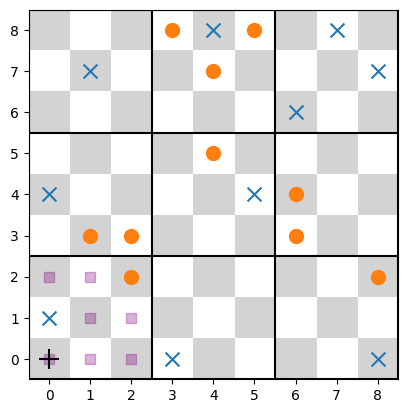

In [77]:

''' -- initialize a board ... '''
engine = uttt_engine()
engine.load_agents(random_bot(name = 'the bot known as player 1'),
                   random_bot(name = 'the second bot'))
''' ... and play some moves randomly -- '''
for i in range(20):
    if engine.finished == False:
        engine.query_player()

''' -- visualize -- '''
engine.draw_board(ticks='on')
engine.draw_valid_moves()


''' -- initialize your bot -- '''
# my_bot = your_bot(name='test version 0.1')
# my_bot = finns_heuristic_bot(name='example logical bot')
my_bot = agent(name=":)")

''' see what your bot thinks is a good move '''
proposed_move = my_bot.move(engine.get_query_dict())

''' visualize the proposed move '''
plt.scatter(proposed_move[0],proposed_move[1],marker='+',c='k',s=200)

---
### Final thoughts

Start small and work in teams. There will likely be a lot of overlapping functions, so talk to others about what you are looking for. They may have already written it.

Hints:
 - Try to finish a bot before trying to improve it.
 - If you ever feel unsure about a move, you can return nothing. The engine will interpret any invalid move as random move.
 - Check your bot often and work slowly. Make sure each method performs as expected.
 